# Load Data

In [7]:
dt = 1/60 # fps
delay = 0.083 # s
T = 50  # frames selected for STA

In [8]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import pickle
import stimgenerate as sg
import matplotlib.patches as mpatches
import pandas as pd
import scipy.stats as stats
from scipy.integrate import simpson
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


# Linear filter

In [9]:
def spatial_filterSF(rf,A=1):

    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=1, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))

def gaussian_2dflatten(x, y, sigma_x, sigma_y,mix, widenratio, A=1, x0=0, y0=0):
    d = gaussian_2d(x=x, y=y, sigma_x = sigma_x, sigma_y = sigma_y, A=A, x0=x0, y0=y0) + gaussian_2d(x=x, y=y, sigma_x = widenratio* sigma_x, sigma_y = widenratio*sigma_y, A=mix*A, x0=x0, y0=y0)
    d = d / np.max(d)
    return d 

def generalized_gaussian_2d(x, y, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0):
    """
    2D generalized Gaussian with exponent alpha:
    - alpha = 1: standard Gaussian
    - 0 < alpha < 1: heavier tails (higher kurtosis)
    - alpha > 1: lighter tails
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    Q = ((X - x0)**2 / (2 * sigma_x**2) +
         (Y - y0)**2 / (2 * sigma_y**2))
    d = A * np.exp(- Q**alpha)
    d = d / d[int((len(x)-1)/2),int((len(x)-1)/2+1)]
    return d   # Normalize to max value of 1


# 2) Student's-t / Cauchy-style kernel
def student_t_2d(x, y, sigma_x, sigma_y, nu, A=1.0, x0=0, y0=0):
    """
    2D Student's-t distribution (heavy-tailed):
    - nu: degrees of freedom. Lower nu -> heavier tails
    - For nu=1: Cauchy (Lorentzian) form
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    r2 = ((X - x0)**2 / sigma_x**2 + (Y - y0)**2 / sigma_y**2)
    return A * (1 + r2 / nu) ** (-(nu + 1) / 2)
def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=1, A_s=0.5):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround

def biphasic_temporal_filter(t, p1, p2, tau1, tau2, n):
    t = np.asarray(-t, dtype=float)
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    return term1 - term2
def biphasic_temporal_filter_norm0(t, p1, p2, tau1, tau2, n):
    # Ensure t as positive duration array
    t = np.asarray(-t, dtype=float)
    # Compute the two cascaded low-pass terms
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    # Combine to biphasic raw filter
    filt = term1 - term2

    area = simpson(filt, t)
    filt -= area / (t[-1] - t[0])
    return filt

def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(spatial_rf, noise_input, temporal_filter):   

    T, Y, X = noise_input.shape 
    # x = np.linspace(-(X-1)/2, (X-1)/2, X)
    # y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    # if type == 'gaussian':
    #     spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    # if type == 'difference_of_gaussians':
    #     spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    # if type == 'SFfitting':
    #     spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    # if type == 'gaussian_2dflatten':
    #     spatial_rf = gaussian_2dflatten(x, y, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie
def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate / (1 + np.exp(-gain * (linear_output+C))) 
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")
    
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v


# Parameter settting for model

In [11]:
temporal_filter_V1 = np.load('results/temporal_filter5.npy')
# optimal parameters
# 4 for linear and gain control
# A, multiply the spatial filter
# B, gain control strength
# tau, gain control time window
# pnratio, represents the ratio btw negative part and positive part of temporal filter
# 4 parameters for a sigmoid plus threshold non linear filter


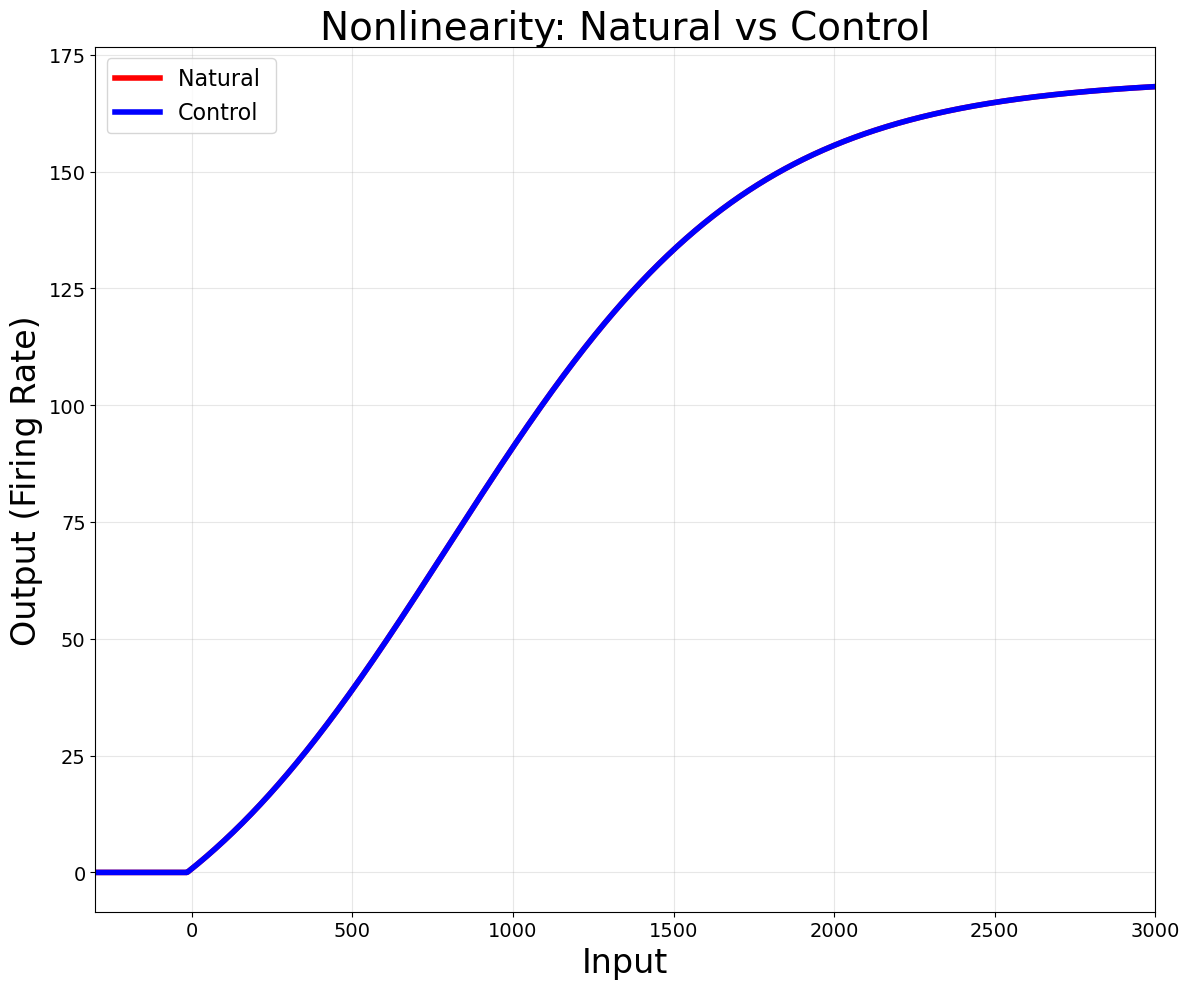

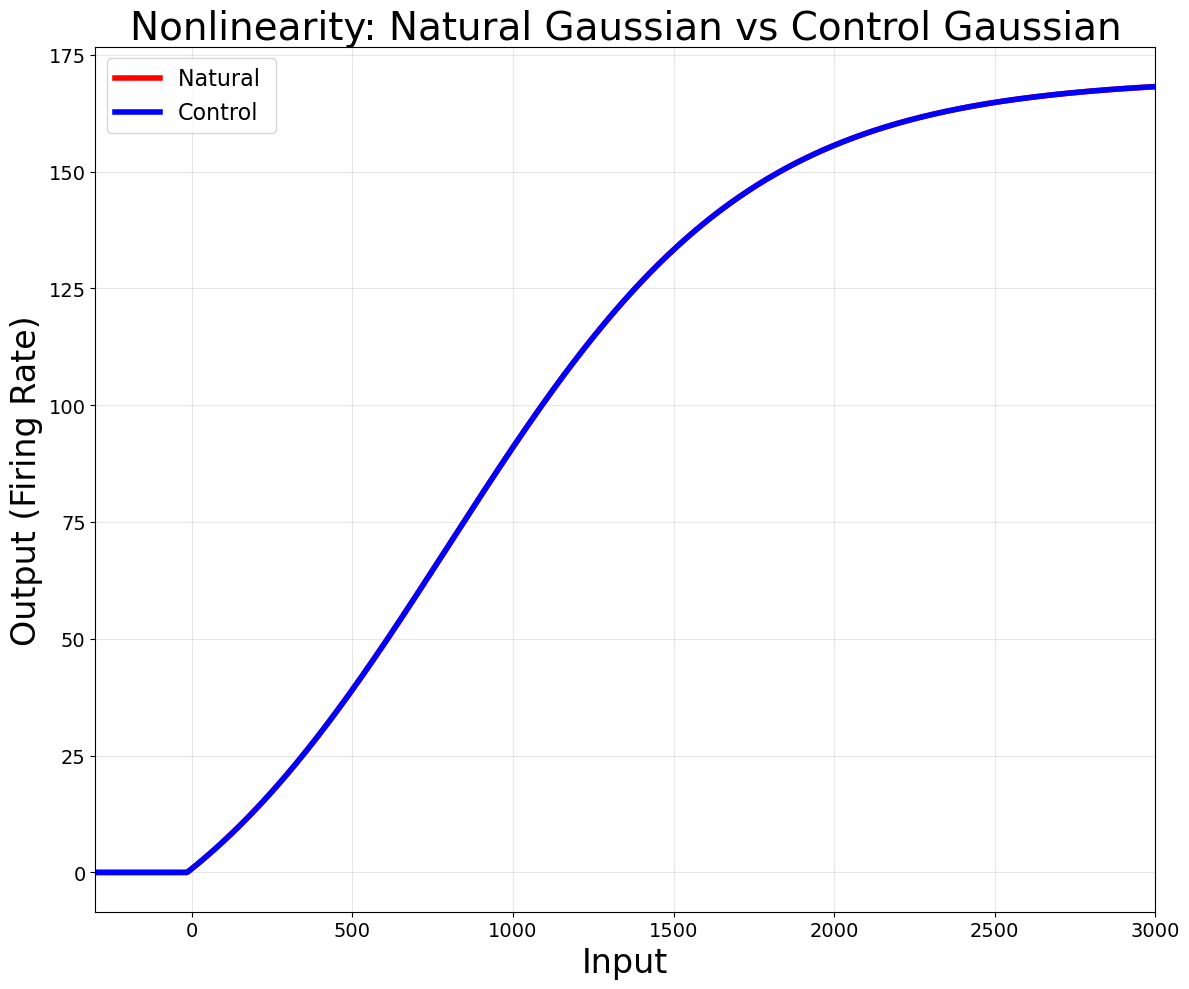

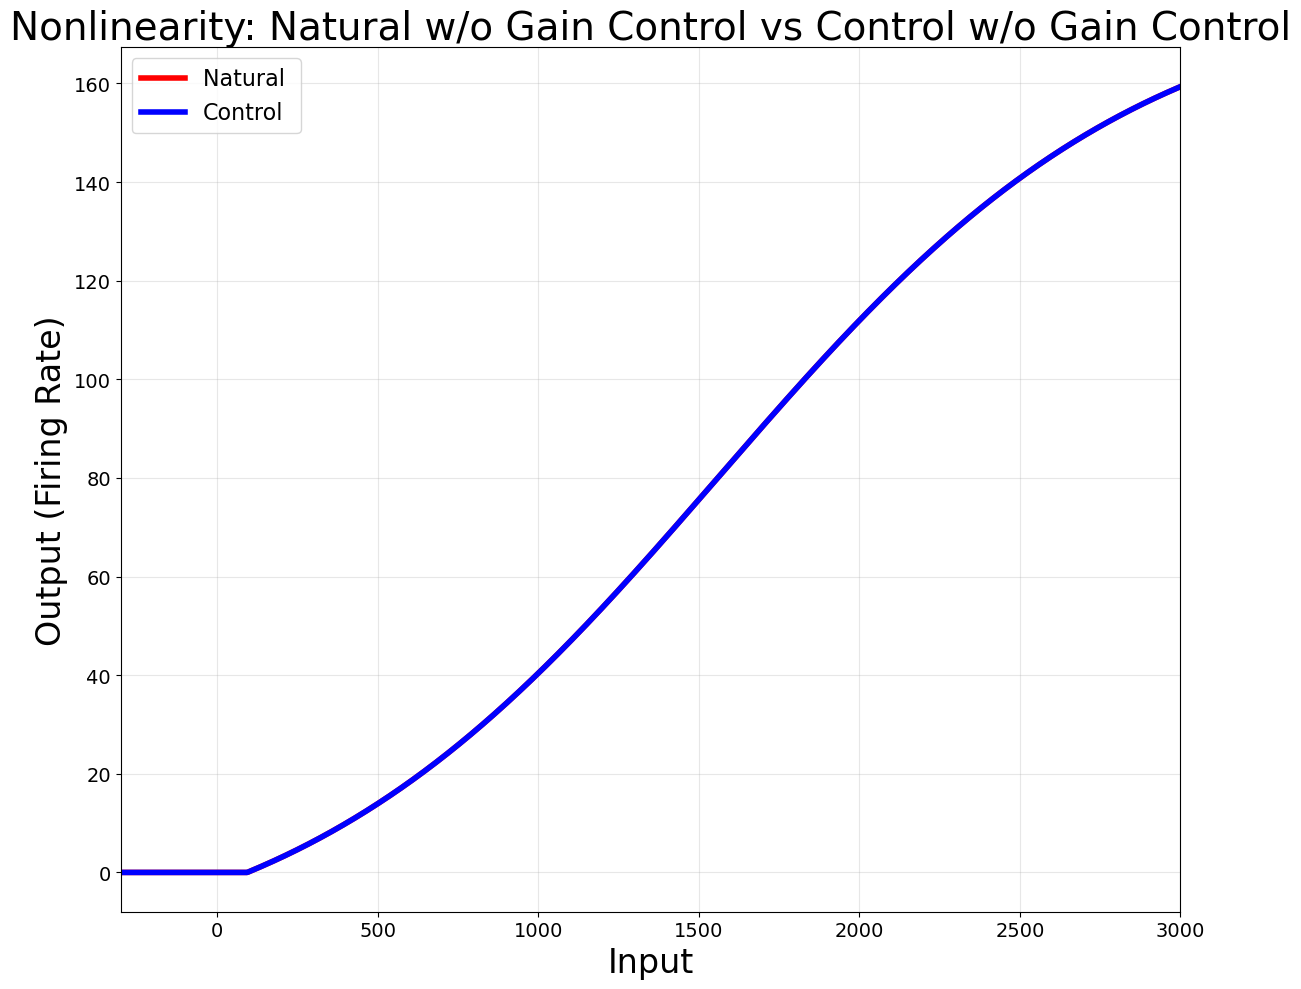

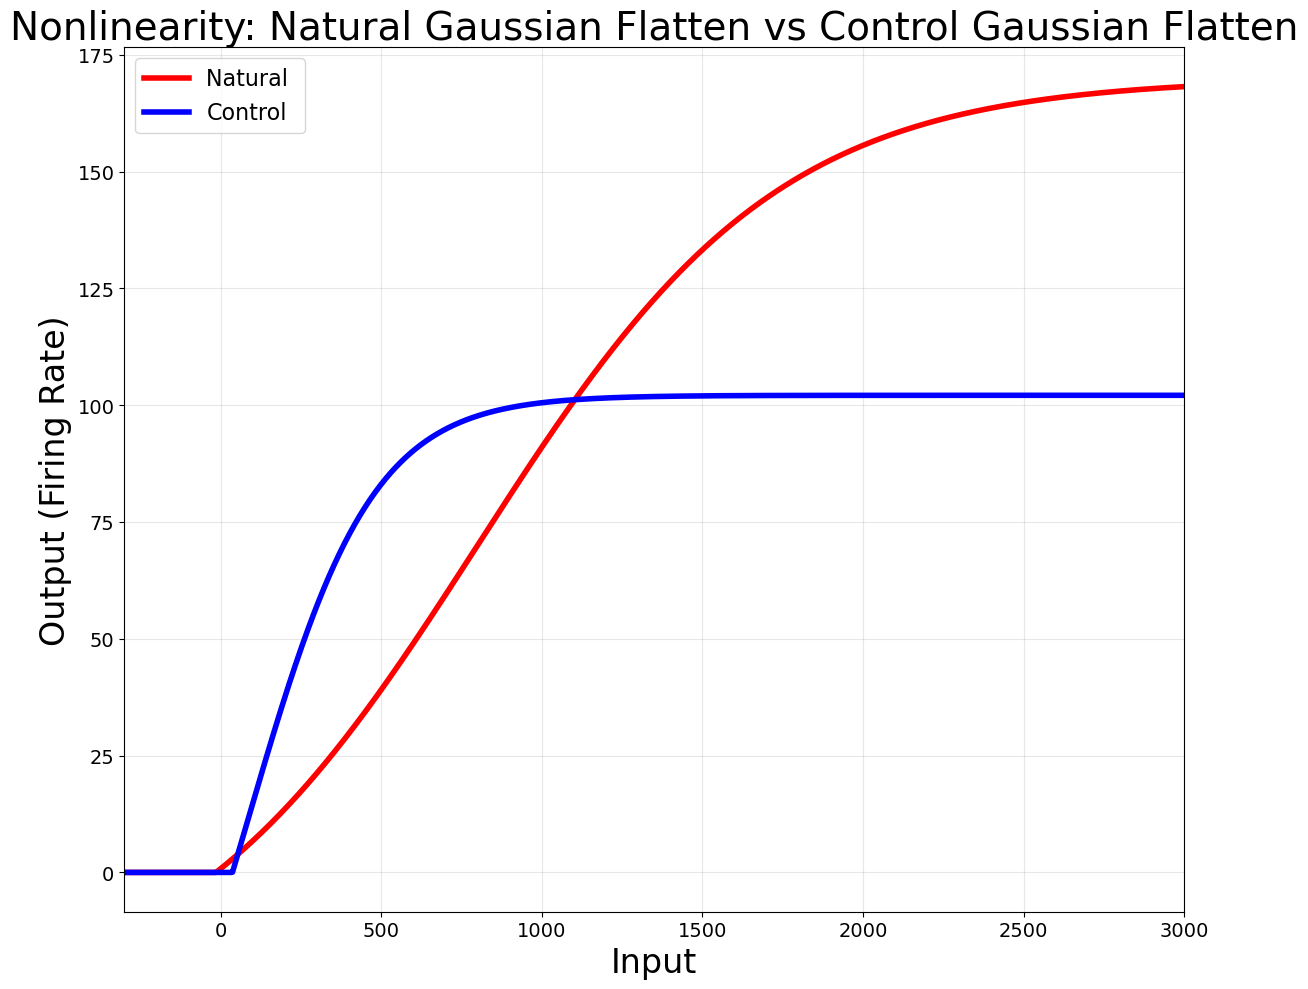

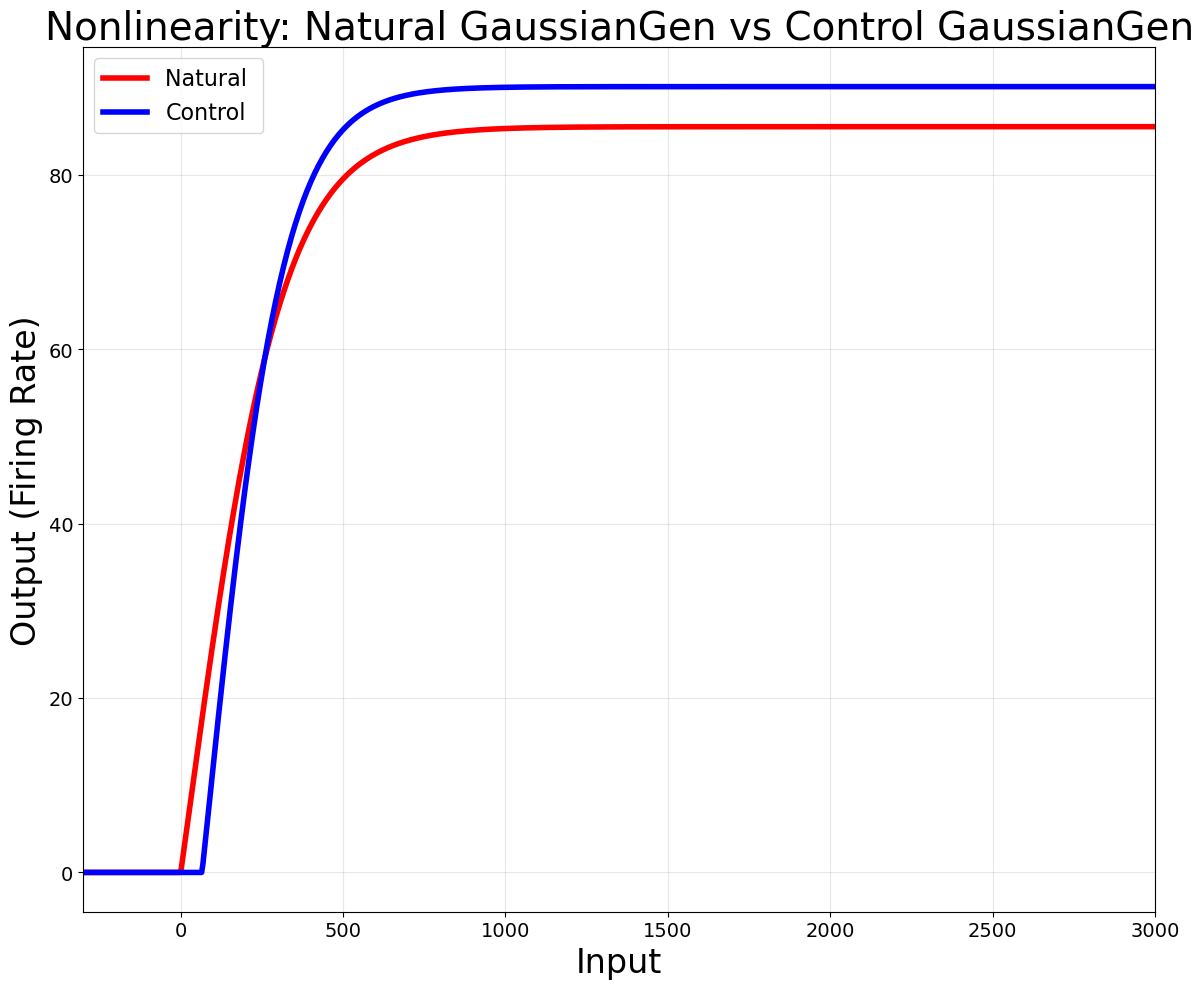

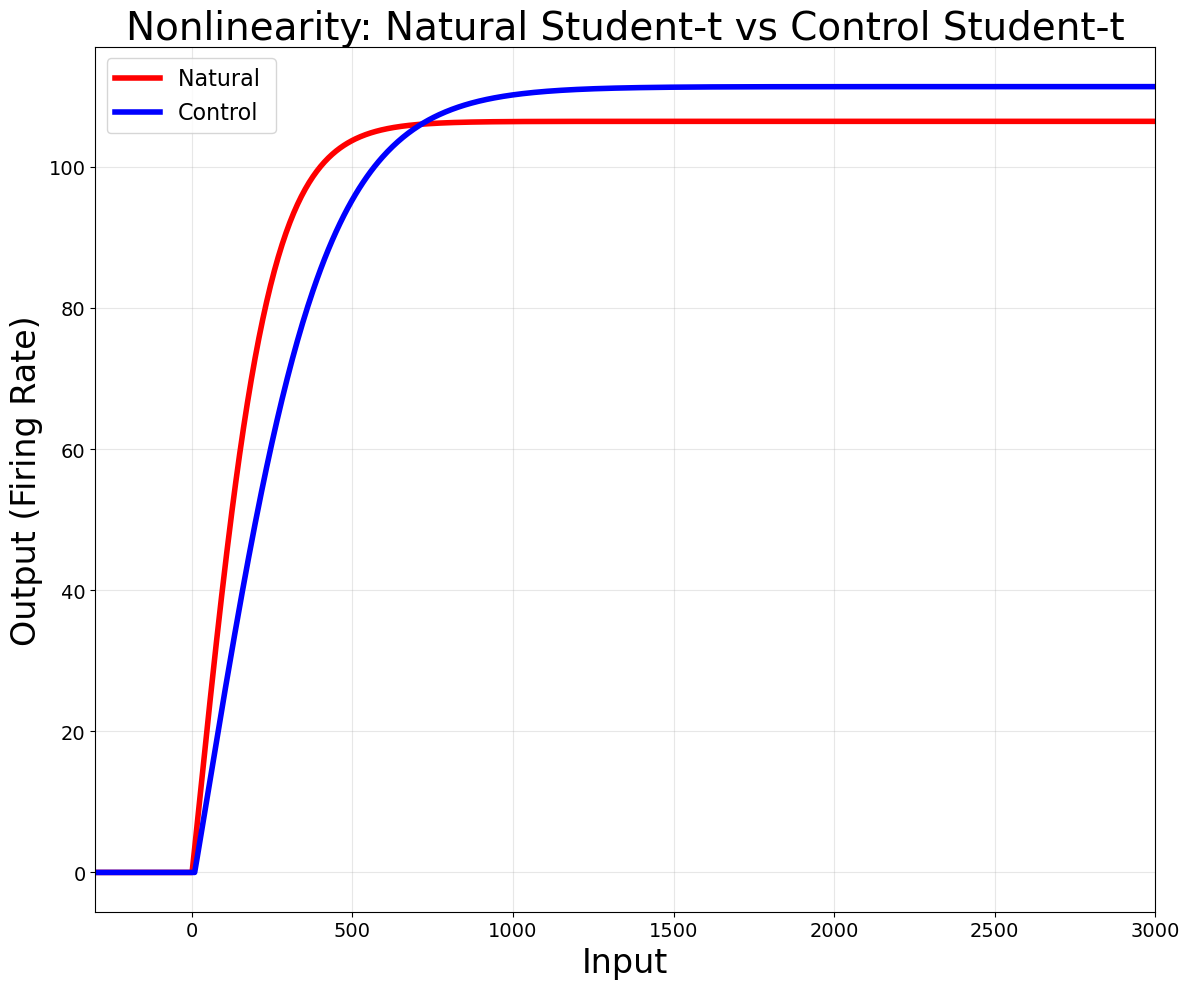

In [12]:

# Define the 6 condition pairs and their titles
condition_pairs = [
    ('natural', 'control'),
    ('natural_gaussian', 'control_gaussian'),
    ('natural_w/o_gaincontrol', 'control_w/o_gaincontrol'),
    ('natural_gaussianflatten', 'control_gaussianflatten'),
    ('natural_gaussianGen', 'control_gaussianGen'),
    ('natural_student_t', 'control_student_t')
]

# Titles for each plot, in the same order as condition_pairs
plot_titles = [
    "Nonlinearity: Natural vs Control",
    "Nonlinearity: Natural Gaussian vs Control Gaussian",
    "Nonlinearity: Natural w/o Gain Control vs Control w/o Gain Control",
    "Nonlinearity: Natural Gaussian Flatten vs Control Gaussian Flatten",
    "Nonlinearity: Natural GaussianGen vs Control GaussianGen",
    "Nonlinearity: Natural Student-t vs Control Student-t"
]

# Parameters for each condition (from your code)
params = {
    'natural': {'gain': 0.00213, 'max_rate': 200, 'y': -800, 'theta': 30},
    'control': {'gain': 0.00213, 'max_rate': 200, 'y': -800, 'theta': 30},
    'natural_gaussian': {'gain': 0.00213, 'max_rate': 200, 'y': -800, 'theta': 30},
    'control_gaussian': {'gain': 0.00213, 'max_rate': 200, 'y': -800, 'theta': 30},
    'natural_w/o_gaincontrol': {'gain': 0.0015, 'max_rate': 200, 'y': -1559, 'theta': 20},
    'control_w/o_gaincontrol': {'gain': 0.0015, 'max_rate': 200, 'y': -1559, 'theta': 20},
    'natural_gaussianflatten': {'gain': 0.00213, 'max_rate': 200, 'y': -800, 'theta': 30},
    # 'natural_gaussianflatten': {'gain': 0.004545293796018254, 'max_rate': 187.8839335009455, 'y': -190.96937964264328, 'theta': 62.14539986205705},
    'control_gaussianflatten': {'gain': 0.005167895796580307, 'max_rate': 181.81073029192413, 'y': -84.77972253021717, 'theta': 79.69957192815914},
    'natural_gaussianGen': {'gain': 0.0067756980878963535, 'max_rate': 159.9339258354442, 'y': -21.160840485288347, 'theta': 74.43809001411122},
    'control_gaussianGen': {'gain': 0.008351077202947548, 'max_rate': 170.6176092399276, 'y': -79.68722771262551, 'theta': 80.52951256652139},
    'natural_student_t': {'gain': 0.008882754610280263, 'max_rate': 197.7624061798797, 'y': -18.452088835880147, 'theta': 91.32321642514742},
    'control_student_t': {'gain': 0.005387110123236081, 'max_rate': 204.2292354819619, 'y': -42.899625911306494, 'theta': 92.86965584673743}
}

# Create input range for plotting
x_range = np.linspace(-1000, 3000, 1000)

# Plot each pair separately with correct titles
for idx, (nat_cond, ctrl_cond) in enumerate(condition_pairs):
    plt.figure(figsize=(12, 10))
    
    # Get parameters for both conditions
    nat_params = params[nat_cond]
    ctrl_params = params[ctrl_cond]
    
    # Apply nonlinearity for natural condition
    output_nat = apply_nonlinearity(
        apply_nonlinearity(x_range, method='sigmoid', gain=nat_params['gain'], max_rate=nat_params['max_rate'], y=nat_params['y']), 
        method='threshold_linear', theta=nat_params['theta']
    )
    
    # Apply nonlinearity for control condition
    output_ctrl = apply_nonlinearity(
        apply_nonlinearity(x_range, method='sigmoid', gain=ctrl_params['gain'], max_rate=ctrl_params['max_rate'], y=ctrl_params['y']), 
        method='threshold_linear', theta=ctrl_params['theta']
    )
    
    # Plot both conditions
    plt.plot(x_range, output_nat, 'red', linewidth=4, label='Natural ')
    plt.plot(x_range, output_ctrl, 'blue', linewidth=4, label='Control')
    
    plt.xlabel('Input', fontsize=24)
    plt.ylabel('Output (Firing Rate)', fontsize=24)
    plt.title(plot_titles[idx], fontsize=28)
    plt.legend(fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.xlim(-300, 3000)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()